In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append("/home/pervinco/BKAI_MetaPolyp")

import cv2
import yaml
import copy
import random
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from glob import glob
from scipy import ndimage
from data.batch_preprocess import load_img_mask, train_img_mask_transform
from utils.utils import decode_mask, decode_image, visualize

In [2]:
with open("/home/pervinco/BKAI_MetaPolyp/config.yaml", "r") as f:
    config = yaml.safe_load(f)

data_dir = config["data_dir"]
image_dir = f"{data_dir}/train"
mask_dir = f"{data_dir}/train_mask"
gt_dir = f"{data_dir}/train_gt"

In [3]:
image_files = sorted(glob(f"{image_dir}/*"))
# mask_files = sorted(glob(f"{mask_dir}/*"))
# gt_files = sorted(glob(f"{gt_dir}/*"))

mask_files = sorted(glob(f"{gt_dir}/*"))

In [4]:
paste_transform = A.Compose([A.RandomBrightnessContrast(p=0.5),
                             A.OneOf([A.HorizontalFlip(p=0.25),
                                      A.VerticalFlip(p=0.25)], p=1),
])

In [5]:
def spatially_exclusive_pasting(image, mask, alpha=0.7, iterations=10, transform=None):
    target_image, target_mask = copy.deepcopy(image), copy.deepcopy(mask)
    L_gray = cv2.cvtColor(target_mask, cv2.COLOR_BGR2GRAY)

    contours, _ = cv2.findContours(L_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        If = target_image[y:y+h, x:x+w]
        Lf_color = target_mask[y:y+h, x:x+w]
        Lf_gray = L_gray[y:y+h, x:x+w]
        
        M = np.random.rand(*target_image.shape[:2])
        M[L_gray == 1] = float('inf')
        
        for _ in range(iterations):
            px, py = np.unravel_index(M.argmin(), M.shape)
            candidate_area = (slice(px, px + h), slice(py, py + w))
            
            if candidate_area[0].stop > target_image.shape[0] or candidate_area[1].stop > target_image.shape[1]:
                M[px, py] = float('inf')
                continue
            
            if np.any(L_gray[candidate_area] & Lf_gray):
                M[candidate_area] = float('inf')
                continue
            
            crop_image, crop_mask = train_img_mask_transform(transform, If, Lf_color)
            target_image[candidate_area] = alpha * target_image[candidate_area] + (1 - alpha) * crop_image
            target_mask[candidate_area] = alpha * target_mask[candidate_area] + (1 - alpha) * crop_mask
            L_gray[candidate_area] = cv2.cvtColor(target_mask[candidate_area], cv2.COLOR_BGR2GRAY)
            
            M[candidate_area] = float('inf')
            
            kernel = np.ones((3, 3), np.float32) / 9
            M = cv2.filter2D(M, -1, kernel)

    return target_image, target_mask


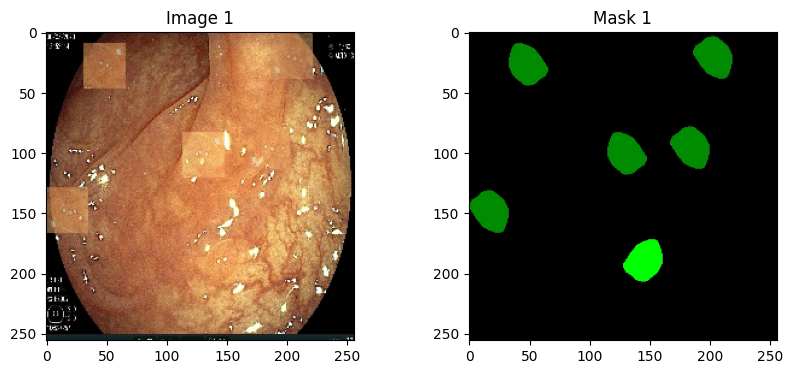

In [19]:
total_files = list(zip(image_files, mask_files))
random.shuffle(total_files)

for image_file, mask_file in total_files:
    image, mask = load_img_mask(image_file, mask_file)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    result_image, result_mask = spatially_exclusive_pasting(image, mask, alpha=0.45, iterations=10, transform=paste_transform)

    visualize([result_image], [result_mask])

    break